# Parameter - Audit

 [boxplot](http://www.math.wpi.edu/saspdf/stat/chap18.pdf)
 [git](http://wresch.github.io/2013/03/08/asinh-scales-in-ggplot2.html)
 [stack](https://stackoverflow.com/questions/37446064/i-need-ggplot-scale-x-log10-to-give-me-both-negative-and-positive-numbers-as-o)

In [9]:
# def visual(df, st):
#     import pandas as pd
#     import numpy as np
#     from plotnine import ggplot, geom_boxplot, geom_line, aes, stat_smooth, facet_wrap
#     from plotnine import options
    
    
#     ggplot(stack(df), aes(x = ind, y = values)) + geom_boxplot()

In [10]:
import numpy as np
from plotnine import *
import pandas as pd
from mizani.transforms import trans
%matplotlib inline

In [11]:
def cleanIparm(ruta, pfile, dcol, df, st):
    import pandas as pd
    from pathlib import Path
    dat_dir = Path(ruta)
    df1 = pd.read_csv(dat_dir / pfile, header = 0)
    ldcol = df1.loc[:, dcol]    # list with column dcol
    df.drop(ldcol, axis=1, inplace=True)    # delete params list in dataframes
    st.drop(ldcol, axis=0, inplace=True)
    return df, st

In [12]:
def cleanIparm2(df, st):
    import pandas as pd
    n = len(df.index)
    # ldcol = st.loc[]
    df.drop(st[st['StdDev'] == 0].index, axis = 1, inplace=True)
    st.drop(st[st['StdDev'] == 0].index, inplace=True)
    df.drop(st[st['NoModeQty'] == 0].index, axis = 1, inplace=True)
    st.drop(st[st['NoModeQty'] == 0].index, inplace=True)
    df.drop(st[st['NaNQty'] > n * .2].index, axis = 1, inplace=True)
    st.drop(st[st['NaNQty'] > n * .2].index, inplace=True)
    # st.sort_values(by=['IQR', 'CV'], ascending=False)
    return df, st

In [13]:
def iqrcalc(q1, q3, n, std, mean):
    import numpy as np
    if .1 > mean > -.1:
        cv = 100*std
    else:
        cv = 100*std/abs(mean)
    return q3 + (1.58 * (q3 - q1)/np.sqrt(n)), q1 - (1.58 * (q3 - q1)/np.sqrt(n)), q3 - q1, cv

In [14]:
def par_audit(ruta, datb, tablas, tipo, carrier):
    import tkinter as tk
    import sqlite3
    import pandas as pd
    import timeit
    import functools
    from pyexcelerate import Workbook
    from pathlib import Path
    from datetime import date
    # top= tk.Toplevel()
    # top.title("Process Progress")
    # top.geometry("300x600+750+120")
    # top.iconbitmap('IT.ico')
    dat_dir = Path(ruta)
    db_path1 = dat_dir / datb
    start_time = timeit.default_timer()
    conn = sqlite3.connect(db_path1)                # database connection
    c = conn.cursor()
    today = date.today()
    df1 = pd.read_csv(dat_dir / tablas)
    for index, row in df1.iterrows():               # panda row iteration tablas file by tipo column
        line = row[tipo]
        if not pd.isna(row[tipo]):                  # nan null values validation
            try:
                if carrier == 1:
                    df = pd.read_sql_query("select * from " + line + " where (UARFCN = 4387);",
                                           conn, index_col='WCELName')
                elif carrier == 2:
                    df = pd.read_sql_query("select * from " + line + " where (UARFCN = 9712);",
                                           conn, index_col='WCELName')
                elif carrier == 3:
                    df = pd.read_sql_query("select * from " + line + " where (UARFCN = 9685);",
                                           conn, index_col='WCELName')
                elif carrier == 4:
                    df = pd.read_sql_query("select * from " + line + " where (UARFCN = 4364);",
                                           conn, index_col='WCELName')
                else:
                    df = pd.read_sql_query("select * from " + line + ";",
                                           conn, index_col='WCELName')  # pandas dataframe from sqlite
                n = len(df.index)   # row count
                if line == "WCEL_FULL1":
                    df['PLMN_id'] = df['PLMN_id'].astype('category')
                    df['RNC_id'] = df['RNC_id'].astype('category')
                    # mode stored in columns
                    modes = df.mode(dropna=False)
                    # dummy rows delete
                    modes = modes.dropna(subset=['Sector'])
                    # count of values in df diff from mode in modes
                    data = {col: (~df[col].isin(modes[col])).sum() for col in df.iloc[:, 0:].columns}
                    data1 = {col: df[col].isin(modes[col]).sum() for col in df.iloc[:, 0:].columns}
                    st3 = pd.DataFrame.from_dict(data, orient='index', columns=['NoModeQty'])
                    st3['ModeQty'] = pd.DataFrame.from_dict(data1, orient='index')
                    st3['NoModePer'] = 100 * (st3['NoModeQty'] / (st3['ModeQty'] + st3['NoModeQty']))
                    st3.index.name = 'Parameter'
                    st2 = modes.T
                    st2.columns = ['Mode']
                    st2.index.name = 'Parameter'
                    st1 = pd.DataFrame({'Vmin': df.min(), 'StdDev': df.std(), 'NaNQty': df.isnull().sum(axis=0), 'Mean': df.mean(),
                                        'Q1': df.quantile(.25), 'Q3': df.quantile(.75), 'Median': df.quantile(.5)})
                    st1[['Max', 'Min', 'IQR', 'CV']] = st1.apply(
                        lambda row: iqrcalc(row['Q1'], row['Q3'], n, row['StdDev'],
                                            row['Mean']), axis=1, result_type='expand')
                    st1.index.name = 'Parameter'
                    # df merge
                    dfs = [st1, st2, st3]
                    st4 = functools.reduce(lambda left, right: pd.merge(left, right, on='Parameter'), dfs)
                    st4.sort_values(by=['IQR', 'CV'], inplace=True, ascending=[False, False])
                    # df.sort_values(['a', 'b'], ascending=[True, False])
                    output = 'parametros.csv'
                    st4.to_csv(dat_dir / output)
            except sqlite3.Error as error:  # sqlite error handling
                print('SQLite error: %s' % (' '.join(error.args)))
                feedbk = tk.Label(top, text='SQLite error: %s' % (' '.join(error.args)))
                feedbk.pack()
    c.close()
    conn.close()
    return df, st4

In [15]:
class asinh_trans(trans):
    """
    asinh Transformation
    """
#     trans_new(asinh_trans, transform, inverse, breaks=None, minor_breaks=None, _format=None, domain=- inf, inf, doc='', **kwargs)
#     number_of_frets = 20              # Including fret 0
    
#     domain = (0, 60000)
    
#     domain = (0, number_of_frets-1)
    @staticmethod
    def transform(y):
        y = np.asarray(y)
        return np.arcsinh(y)
    @staticmethod
    def inverse(y):
        y = np.asarray(y)
        return np.sinh(y)
#     @classmethod
#     def breaks_(cls, limits):
#         # Fixed major breaks
#         return cls.domain
#     @classmethod
#     def minor_breaks(cls, major, limits):
#         # The major breaks as passed to this method are in transformed space.
#         # The minor breaks are calculated in data space to reveal the
#         # non-linearity of the scale.
#         _major = cls.inverse(major)
#         minor = cls.transform(np.linspace(*_major, cls.number_of_frets))
#         return minor
    

# R code    
# limits <- 100
# step <- 0.005
# demo <- data.frame(x=seq(from=-1*limits,to=limits,by=step))
# asinh_trans <- function(){
#   trans_new(name = 'asinh', transform = function(x) asinh(x), 
#             inverse = function(x) sinh(x))
# }
# ggplot(demo,aes(x,x))+geom_point(size=2)+
#      scale_y_continuous(trans = 'asinh',breaks=c(-100,-50,-10,-1,0,1,10,50,100))+
#      theme_bw()

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 20 x 10 in image.
C:\ProgramData\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: scatterplot.png
C:\ProgramData\Anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
C:\ProgramData\Anaconda3\lib\site-packages\plotnine\stats\stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
C:\ProgramData\Anaconda3\lib\site-packages\plotnine\facets\facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
C:\ProgramData\Anaconda3\lib\site-packages\plotnine\facets\facet.py:555: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adju

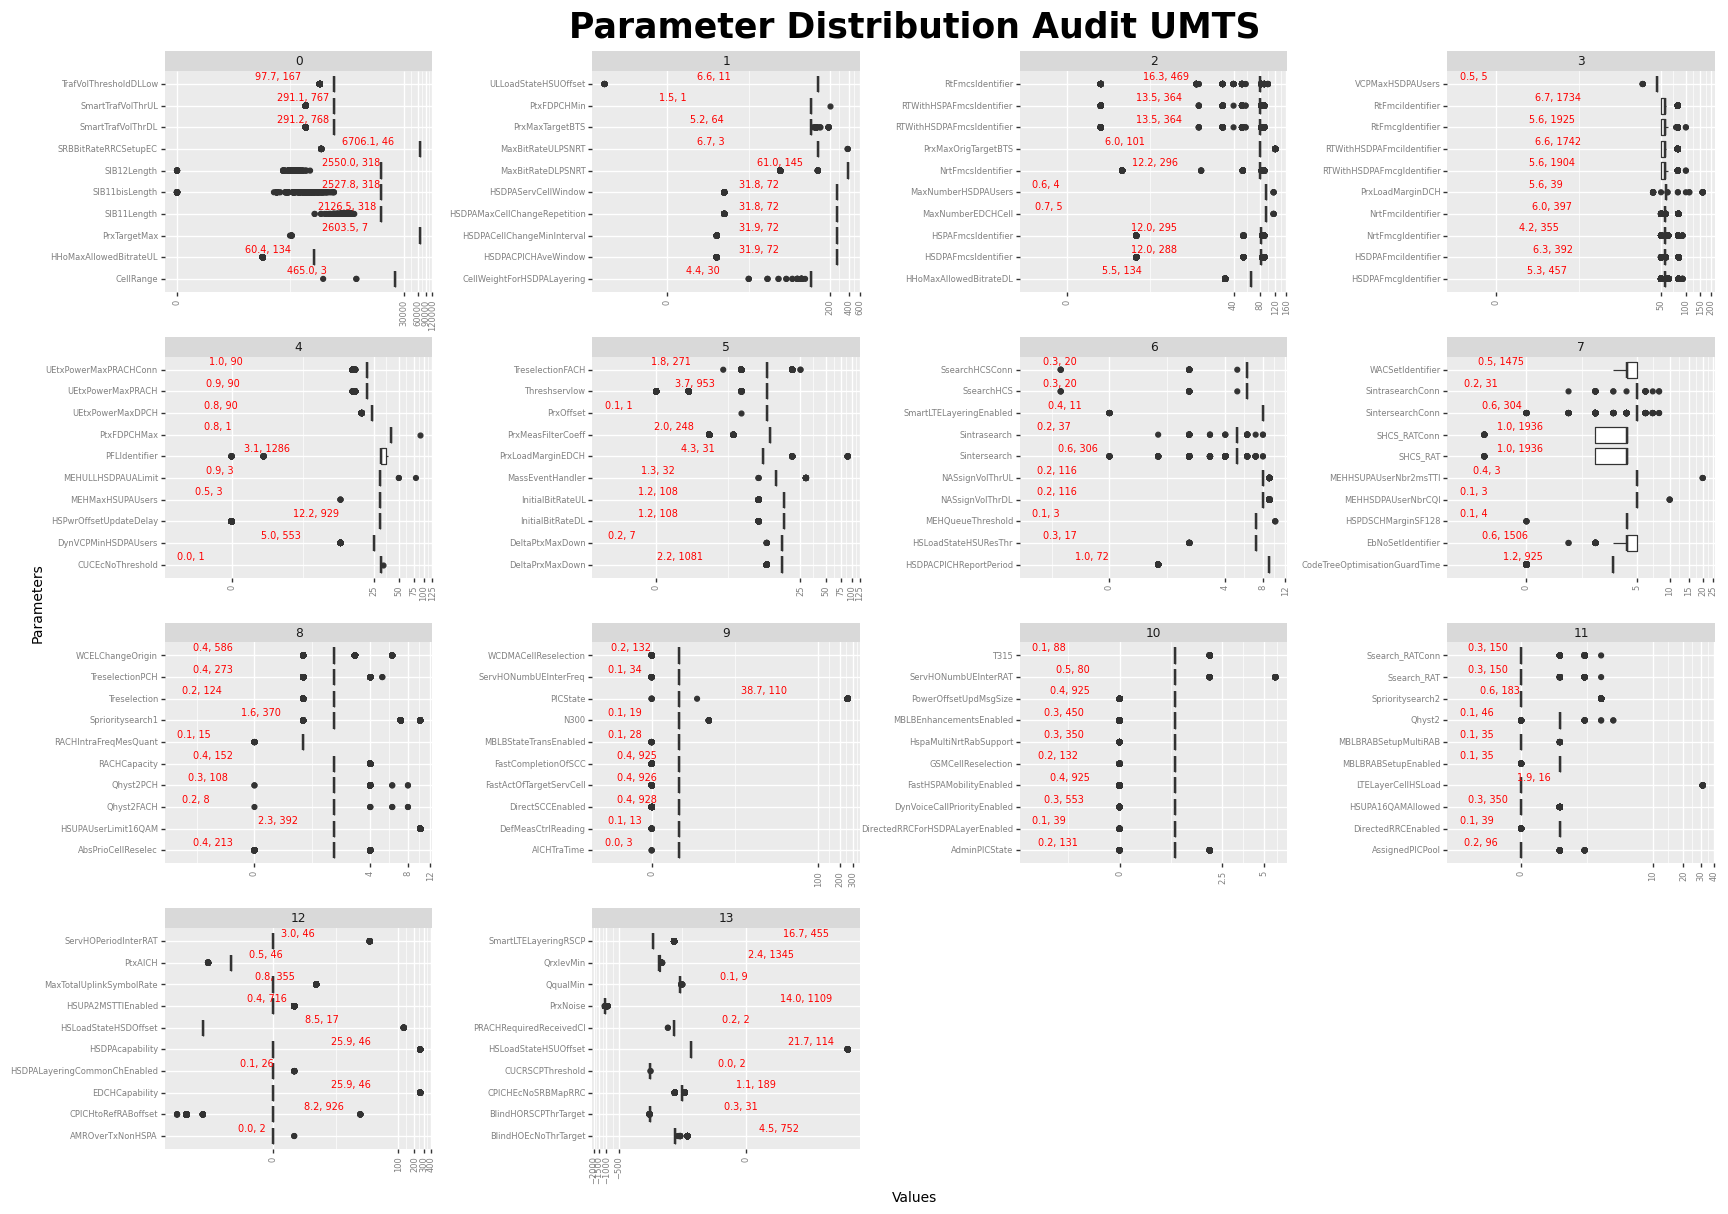

<ggplot: (89781552363)>

In [16]:
df, st = par_audit("C:/SQLite", "20200522_sqlite.db", "tablasSQL.csv", "audit2", 1)
df, st = cleanIparm("C:/SQLite", "ExParam.csv", "expar", df, st)
df, st = cleanIparm2(df, st)
st.sort_values(by=['Median'], inplace=True, ascending=[False])   #for better visualization
# counter controls number of boxplots
st['counter'] = range(len(st))
st['counter'] = st['counter'].floordiv(10) # split parameters in groups by 10
# add column with parameter names
st['parameter'] = st.index
cols = ['StdDev', 'Mean', 'Median', 'Max', 'Min', 'CV']
st[cols] = st[cols].round(1)    #scales colums with 1 decimal digit
# concat info to put text in boxplots
st['concat'] = st['StdDev'].astype(str) + ', ' + st['NoModeQty'].astype(str)
# create sequence to use in melt operation
df["id"] = range(len(df))
ldcol = list(st.index)      # parameters to include in melt command
# Structuring df1 according to ‘tidy data‘ standard
df1 = df.melt(id_vars=['id'], value_vars=ldcol, var_name='parameter', value_name='value')
result = pd.merge(df1, st, on=['parameter', 'parameter'])  # merging stat and raw data
# axis scaling
result['value_scale'] = np.arcsinh(result['value'])
# graph code
# theme adjust
custom_axis = theme(axis_text_x = element_text(color="grey", size=6, angle=90, hjust=.3),
                    axis_text_y = element_text(color="grey", size=6), 
                    plot_title = element_text(size = 25, face = "bold"), 
                    axis_title = element_text(size = 10), 
                    panel_spacing_x=1.6, panel_spacing_y=.45, 
                    # 2nd value number of rows and colunms
                    figure_size=(5 * 4, 3.5 * 4) 
                    ) 
# ggplot code
my_plot = (ggplot(data = result, mapping = aes(x='parameter', y='value')) + geom_boxplot() +
    # value 'concat' is placed in coordinate (parameter, stddev), 
    geom_text(data= st, mapping = aes(x='parameter', y='StdDev', label='concat'), 
              color = 'red', va = 'top', ha = 'left', size = 7, nudge_x=.6, nudge_y=-1.5) + 
    facet_wrap('counter', scales = 'free') + custom_axis + scale_y_continuous(trans=asinh_trans) + 
    ylab("Values") + xlab("Parameters") + labs(title="Parameter Distribution Audit UMTS") + 
    coord_flip())
my_plot.save("scatterplot.png", width=20, height=10, dpi=300)
my_plot

# + scale_y_continuous(trans=asinh_trans, breaks=[-100,-50,-10,-1,0,1,10,50,100]))